In [91]:
import warnings
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split
plt.rcParams['font.sans-serif']=['SimHei']

In [75]:
data=pd.read_csv('order_train1.csv')
data.columns=['订单日期', '销售区域编码', '产品编码', '产品大类编码',
       '产品细类编码', '销售渠道名称', '产品价格', '订单需求量']
data.head()

,订单日期,销售区域编码,产品编码,产品大类编码,产品细类编码,销售渠道名称,产品价格,订单需求量
0,2015-09-01,104,22069,307,403,offline,1114.0,19
1,2015-09-01,104,20028,301,405,offline,1012.0,12
2,2015-09-02,104,21183,307,403,online,428.0,109
3,2015-09-02,104,20448,308,404,online,962.0,3
4,2015-09-02,104,21565,307,403,offline,1400.0,3


In [76]:
data['订单日期']=pd.to_datetime(data['订单日期'], format='%Y-%m-%d')
data['日']=data['订单日期'].dt.day
data['周']=data['订单日期'].dt.week
data['月']=data['订单日期'].dt.month

In [77]:
data=data[['订单日期','日', '周', '月','销售区域编码', '产品编码', '产品大类编码', '产品细类编码','订单需求量']]

In [78]:
data['组合']=(data['销售区域编码'].map(str)+data['产品编码'].map(str))

In [79]:
temp=pd.read_csv('predict_sku1.csv')
temp.columns=['销售区域编码', '产品编码', '产品大类编码', '产品细类编码']
temp.head()

,销售区域编码,产品编码,产品大类编码,产品细类编码
0,101,20002,303,406
1,101,20003,301,405
2,101,20006,307,403
3,101,20011,303,401
4,101,20014,307,403


In [80]:
temp['组合']=(temp['销售区域编码'].map(str)+temp['产品编码'].map(str))

In [81]:
data['年月']=data['订单日期'].map(str).apply(lambda x:x[:7])

In [82]:
data

,订单日期,日,周,月,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量,组合,年月
0,2015-09-01,1,36,9,104,22069,307,403,19,10422069,2015-09
1,2015-09-01,1,36,9,104,20028,301,405,12,10420028,2015-09
2,2015-09-02,2,36,9,104,21183,307,403,109,10421183,2015-09
3,2015-09-02,2,36,9,104,20448,308,404,3,10420448,2015-09
4,2015-09-02,2,36,9,104,21565,307,403,3,10421565,2015-09
...,...,...,...,...,...,...,...,...,...,...,...
597689,2018-12-20,20,51,12,102,20994,302,408,59,10220994,2018-12
597690,2018-12-20,20,51,12,102,21875,302,408,502,10221875,2018-12
597691,2018-12-20,20,51,12,102,20215,302,408,106,10220215,2018-12
597692,2018-12-20,20,51,12,102,20195,302,408,187,10220195,2018-12


In [ ]:
# 以月为时间粒度建立模型 这里全部以XGboost作为预测模型

In [83]:
temp['组合']

0       10120002
1       10120003
2       10120006
3       10120011
4       10120014
          ...   
2614    10522066
2615    10522072
2616    10522075
2617    10522083
2618    10522084
Name: 组合, Length: 2619, dtype: object

In [152]:
def calculate_metrics(train_y, train_pred):
    mae = mean_absolute_error(train_y, train_pred)
    mse = mean_squared_error(train_y, train_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [96]:
%%time
ttt=[]
count=0
mae_list = []
rmse_list = []
print("xgBoost回归")
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('年月').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        train_x,test_x,train_y,test_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        model=xgb.XGBRegressor()
        model.fit(train_x,train_y)
        y_pred = model.predict(test_x)
        train_pred = model.predict(train_x)
        
        mae, mse, rmse = calculate_metrics(train_y, train_pred)
        mse_list.append(mse)
        mae_list.append(mae)
        rmse_list.append(rmse)
        
        x_input=Y.tolist()[-3:]
        predict_forword_number=3
        predict_list=[]
        while len(predict_list) < predict_forword_number:
            yhat =model.predict(np.array(x_input).reshape(1,-1))
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]
        ttt.append([i,mae,mse,rmse,predict_list[0],predict_list[1],predict_list[2]])
    except:
        continue

xgBoost回归
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
Wall time: 2min 56s


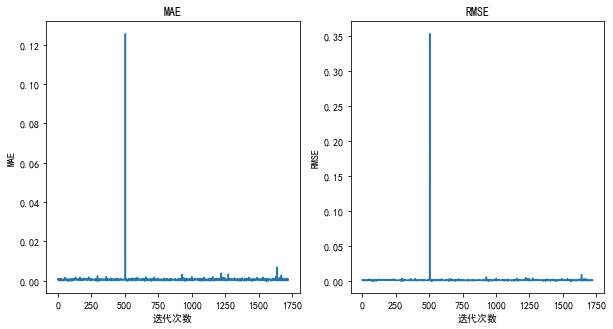

In [97]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mae_list)
plt.title('MAE')
plt.xlabel('迭代次数')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(rmse_list)
plt.title('RMSE')
plt.xlabel('迭代次数')
plt.ylabel('RMSE')

plt.show()

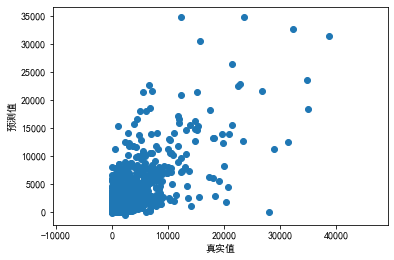

In [103]:
predictions = []
true_values = []
for item in ttt:
    predictions.append(item[-3:])
    true_values.append(data[data['组合']==item[0]].groupby('年月').sum()['订单需求量'].values[-3:])

# 将列表转换为 numpy 数组
predictions = np.array(predictions)
true_values = np.array(true_values)

# 绘制散点图
plt.scatter(true_values, predictions)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [100]:
model_result1=pd.DataFrame(ttt,columns=['组合','Mae','Mse','Rmse','Train_score','Test_score','2019年1月预测需求量','2019年2月预测需求量','2019年3月预测需求量'])

In [101]:
model_result1.head()

,组合,Mae,Mse,Rmse,Mape_val,2019年1月预测需求量,2019年2月预测需求量,2019年3月预测需求量
0,10120002,0.000874,8.932974e-07,0.000945,0.002147,19.467485,40.724682,19.000746
1,10120003,0.000565,5.971880e-07,0.000773,0.000209,519.440613,246.365967,935.518555
2,10120006,0.000621,6.316665e-07,0.000795,0.000657,145.258896,120.167206,156.157471
3,10120014,0.000642,1.044886e-06,0.001022,0.002921,16.000307,2.005131,2.005131
4,10120016,0.000594,6.198534e-07,0.000787,0.000064,1513.518677,147.859146,553.000366


In [85]:
%%time
ttt=[]
count=0
mae_list = []
rmse_list = []
print("决策树回归")
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('年月').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        train_x,test_x,train_y,test_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        tree=DecisionTreeRegressor(max_depth=50,random_state=0)
        tree.fit(train_x,train_y)
        y_pred = tree.predict(test_x)
        train_pred = tree.predict(train_x)
        mae, mse, rmse, mape_val = calculate_metrics(train_y, train_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        
        x_input=Y.tolist()[-3:]
        predict_forword_number=3
        predict_list=[]
        while len(predict_list) < predict_forword_number:
            yhat =tree.predict(np.array(x_input).reshape(1,-1))
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]
        ttt.append([i,mae,mse,rmse,mape_val,predict_list[0],predict_list[1],predict_list[2]])
    except:
        continue

决策树回归
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
Wall time: 1min 39s


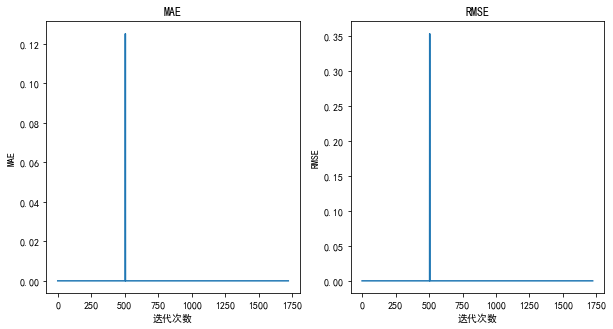

In [86]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mae_list)
plt.title('MAE')
plt.xlabel('迭代次数')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(rmse_list)
plt.title('RMSE')
plt.xlabel('迭代次数')
plt.ylabel('RMSE')

plt.show()

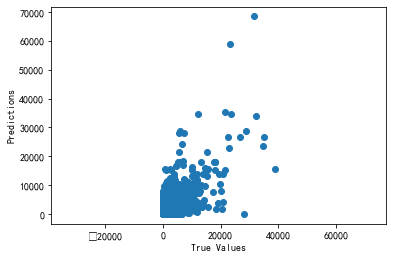

In [87]:
predictions = []
true_values = []
for item in ttt:
    predictions.append(item[-3:])
    true_values.append(data[data['组合']==item[0]].groupby('年月').sum()['订单需求量'].values[-3:])

# 将列表转换为 numpy 数组
predictions = np.array(predictions)
true_values = np.array(true_values)

# 绘制散点图
plt.scatter(true_values, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [72]:
model_result2=pd.DataFrame(ttt,columns=['组合','Mae','Mse','Rmse','Mape_val','2019年1月预测需求量','2019年2月预测需求量','2019年3月预测需求量'])

In [73]:
model_result2.head()

,组合,Mae,Mse,Rmse,Mape_val,2019年1月预测需求量,2019年2月预测需求量,2019年3月预测需求量


In [49]:
model_result2[['Mae','Mse','Rmse','Mape_val']].mean()

Mae         0.000077
Mse         0.000077
Rmse        0.000218
Mape_val    0.000865
dtype: float64

In [50]:
model_result2[['Mae','Mse','Rmse','Mape_val']].describe()

,Mae,Mse,Rmse,Mape_val
count,1625.000000,1625.000000,1625.000000,1625.000000
mean,0.000077,0.000077,0.000218,0.000865
std,0.003101,0.003101,0.008771,0.034885
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.125000,0.125000,0.353553,1.406250


In [104]:
%%time
ttt=[]
count=0
mae_list = []
rmse_list = []
print("随机森林回归")
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('年月').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        train_x,test_x,train_y,test_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        rf=RandomForestRegressor(max_depth=20,n_estimators=1000,random_state=0)
        rf.fit(train_x,train_y)
        y_pred = rf.predict(test_x)
        train_pred = rf.predict(train_x)
        mae, mse, rmse, mape_val = calculate_metrics(train_y, train_pred)
        x_input=Y.tolist()[-3:]
        predict_forword_number=3
        predict_list=[]
        while len(predict_list) < predict_forword_number:
            yhat =rf.predict(np.array(x_input).reshape(1,-1))
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]
        ttt.append([i,mae,mse,rmse,mape_val,predict_list[0],predict_list[1],predict_list[2]])
    except:
        continue

随机森林回归
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
Wall time: 36min 52s


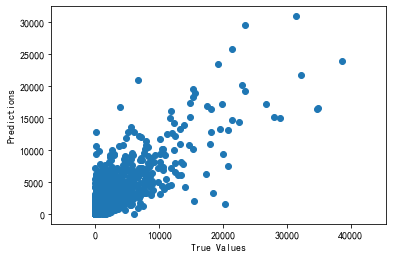

In [105]:
predictions = []
true_values = []
for item in ttt:
    predictions.append(item[-3:])
    true_values.append(data[data['组合']==item[0]].groupby('年月').sum()['订单需求量'].values[-3:])

# 将列表转换为 numpy 数组
predictions = np.array(predictions)
true_values = np.array(true_values)

# 绘制散点图
plt.scatter(true_values, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100, 100], [-100, 100])
plt.show()

In [107]:
model_result3=pd.DataFrame(ttt,columns=['组合','Mae','Mse','Rmse','Mape_val','2019年1月预测需求量','2019年2月预测需求量','2019年3月预测需求量'])

In [108]:
model_result3.head()

,组合,Mae,Mse,Rmse,Mape_val,2019年1月预测需求量,2019年2月预测需求量,2019年3月预测需求量
0,10120002,8.679000,1.153371e+02,10.739511,18.354134,32.055,39.540,30.252
1,10120003,144.501389,3.916686e+04,197.906188,61.137395,533.611,320.042,558.476
2,10120006,43.162611,3.522144e+03,59.347653,38.333875,130.018,127.359,124.378
3,10120014,1181.037385,2.299933e+06,1516.552841,606.849863,193.971,202.105,202.105
4,10120016,373.493300,3.093344e+05,556.178352,29.430104,977.059,371.454,1001.156


In [109]:
model_result3[['Mae','Mse','Rmse','Mape_val']].mean()

Mae            295.602087
Mse         594098.856208
Rmse           387.193014
Mape_val       186.199066
dtype: float64

In [110]:
model_result3[['Mae','Mse','Rmse','Mape_val']].describe()

,Mae,Mse,Rmse,Mape_val
count,1625.000000,1.625000e+03,1625.000000,1625.000000
mean,295.602087,5.940989e+05,387.193014,186.199066
std,513.755670,2.303616e+06,666.673786,403.008680
min,0.000000,0.000000e+00,0.000000,0.000000
25%,26.306687,1.147652e+03,33.877020,35.889458
50%,104.075167,1.855274e+04,136.208435,74.644969
75%,311.283152,1.640967e+05,405.088450,176.088691
max,4314.751111,3.173374e+07,5633.270749,6015.844343


In [16]:
model_result3['sales_region_code']=model_result3['组合'].apply(lambda x:x[:3])
model_result3['item_code']=model_result3['组合'].apply(lambda x:x[3:])

In [18]:
model_result3[['sales_region_code', 'item_code','2019年1月预测需求量', '2019年2月预测需求量',
       '2019年3月预测需求量']].to_excel('result1_月.xlsx',index=None)

In [111]:
data['年周']=data['订单日期'].dt.year.map(str)+'-'+data['订单日期'].dt.week.map(str)

In [112]:
data=data.sort_values('年周')

In [113]:
data.reset_index(inplace=True,drop=True)

In [130]:
data

,订单日期,日,周,月,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量,组合,年月,年周
0,2015-09-01,1,36,9,104,22069,307,403,19,10422069,2015-09,2015-36
1,2015-09-06,6,36,9,102,22046,305,412,208,10222046,2015-09,2015-36
2,2015-09-06,6,36,9,102,21379,305,412,84,10221379,2015-09,2015-36
3,2015-09-06,6,36,9,105,20007,305,412,1007,10520007,2015-09,2015-36
4,2015-09-06,6,36,9,105,21744,302,408,53,10521744,2015-09,2015-36
...,...,...,...,...,...,...,...,...,...,...,...,...
597689,2018-02-27,27,9,2,102,21253,306,407,305,10221253,2018-02,2018-9
597690,2018-02-27,27,9,2,103,20244,308,404,10,10320244,2018-02,2018-9
597691,2018-02-27,27,9,2,103,20704,307,403,56,10320704,2018-02,2018-9
597692,2018-02-27,27,9,2,103,21940,303,401,14,10321940,2018-02,2018-9


In [131]:
%%time
ttt=[]
mae_list = []
rmse_list = []
count=0
for i in temp['组合']:
    count+=1
    if count%20==0:
        print(count)
    try:
        aa=data[data['组合']==i].groupby('年周').sum()['订单需求量'].values
        aa=pd.DataFrame(aa,columns=['订单需求量'])
        aa['shift1']=aa['订单需求量'].shift(1)
        aa['shift2']=aa['订单需求量'].shift(2)
        aa['shift3']=aa['订单需求量'].shift(3)
        aa.dropna(inplace=True)
        X=aa[['shift1', 'shift2', 'shift3']]
        Y=aa['订单需求量']
        tr_x,te_x,tr_y,te_y=train_test_split(X ,Y,test_size=0.1,random_state=5) 
        rf=RandomForestRegressor(max_depth=20,n_estimators=1000,random_state=0)
        rf.fit(tr_x,tr_y)
        y_pred = rf.predict(te_x)
        train_pred = rf.predict(tr_x)
        mae, mse, rmse = calculate_metrics(tr_y, train_pred)
        mae_list.append(mse)
        rmse_list.append(rmse)
        
        x_input=Y.tolist()[-3:]
        predict_forword_number=13
        predict_list=[]
        while len(predict_list) < predict_forword_number:
            yhat =rf.predict(np.array(x_input).reshape(1,-1))
            #预测新值
            predict_list.append(yhat[0])
            x_input=x_input[-2:]+[yhat[0]]
        ttt.append([i,mae,mse,rmse,mape_val,predict_list])
    except:
        continue

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
Wall time: 1h 3min 29s


In [132]:
tad=[]
for l in ttt:
    tad.append(l[:5])
tad=pd.DataFrame(tad,columns=['组合','Mae','Mse','Rmse','Mape_val'])

In [133]:
tad2=[]
for l in ttt:
    tad2.append(l[5])

In [134]:
tad2=pd.DataFrame(tad2)

In [135]:
tad2

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,19.301,20.692,11.416,27.326,18.013,12.361,37.920,14.686,17.542,22.725,11.896,26.253,21.611
1,141.761,103.290,73.795,169.161,117.861,70.075,165.449,236.904,114.244,174.128,234.222,188.093,324.521
2,43.293,96.271,96.421,39.091,48.502,106.254,90.074,40.889,49.374,113.584,86.335,36.102,52.651
3,1528.402,1160.443,1322.297,1569.678,571.335,1617.922,2064.500,1026.307,1842.273,1039.468,732.539,1898.207,700.467
4,299.750,202.684,224.245,263.931,177.893,394.661,311.659,233.814,272.114,150.601,382.814,279.167,220.066
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,8.986,9.069,6.585,9.775,10.752,8.554,7.820,7.097,10.828,8.942,9.030,6.604,9.775
1890,4272.608,989.335,244.769,4036.334,1968.144,755.139,1331.293,1615.493,1160.219,1761.227,1643.769,1748.273,1449.577
1891,548.526,291.336,172.254,320.554,365.039,246.077,313.297,283.906,254.062,304.191,288.204,292.064,292.064
1892,1191.595,677.727,178.572,424.813,366.688,308.405,202.596,291.961,299.904,314.056,231.019,214.435,365.513


In [136]:
tad['2019年1月预测需求量']=tad2[tad2.columns[0]]+tad2[tad2.columns[1]]+tad2[tad2.columns[2]]+tad2[tad2.columns[3]]+tad2[tad2.columns[4]]*(4/7)
tad['2019年2月预测需求量']=tad2[tad2.columns[4]]*(3/7)+tad2[tad2.columns[5]]+tad2[tad2.columns[6]]+tad2[tad2.columns[7]]+tad2[tad2.columns[8]]*(4/7)
tad['2019年3月预测需求量']=tad2[tad2.columns[8]]*(3/7)+tad2[tad2.columns[9]]+tad2[tad2.columns[10]]+tad2[tad2.columns[11]]+tad2[tad2.columns[12]]

In [137]:
ttt_2=tad

In [139]:
ttt_2['sales_region_code']=ttt_2['组合'].apply(lambda x:x[:3])
ttt_2['item_code']=ttt_2['组合'].apply(lambda x:x[3:])

,sales_region_code,item_code,2019年1月预测需求量,2019年2月预测需求量,2019年3月预测需求量
0,101,20002,89.028143,82.710857,90.003000
1,101,20003,555.356143,588.222143,969.925714
2,101,20006,302.791429,286.217286,309.832286
3,101,20014,5907.297143,6006.314286,5160.226571
4,101,20016,1092.263143,1171.867571,1149.268286


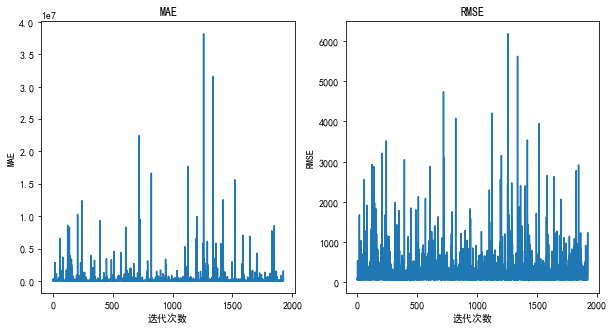

In [141]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mae_list)
plt.title('MAE')
plt.xlabel('迭代次数')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(rmse_list)
plt.title('RMSE')
plt.xlabel('迭代次数')
plt.ylabel('RMSE')

plt.show()

In [143]:
ttt_2[['sales_region_code', 'item_code','2019年1月预测需求量', '2019年2月预测需求量',
       '2019年3月预测需求量']].to_excel('result1_周.xlsx',index=None)

In [146]:
data

,订单日期,日,周,月,销售区域编码,产品编码,产品大类编码,产品细类编码,订单需求量,组合,年月,年周
0,2015-09-01,1,36,9,104,22069,307,403,19,10422069,2015-09,2015-36
1,2015-09-06,6,36,9,102,22046,305,412,208,10222046,2015-09,2015-36
2,2015-09-06,6,36,9,102,21379,305,412,84,10221379,2015-09,2015-36
3,2015-09-06,6,36,9,105,20007,305,412,1007,10520007,2015-09,2015-36
4,2015-09-06,6,36,9,105,21744,302,408,53,10521744,2015-09,2015-36
...,...,...,...,...,...,...,...,...,...,...,...,...
597689,2018-02-27,27,9,2,102,21253,306,407,305,10221253,2018-02,2018-9
597690,2018-02-27,27,9,2,103,20244,308,404,10,10320244,2018-02,2018-9
597691,2018-02-27,27,9,2,103,20704,307,403,56,10320704,2018-02,2018-9
597692,2018-02-27,27,9,2,103,21940,303,401,14,10321940,2018-02,2018-9
